### Мультиномиальная логистическая регрессия и оценка качества моделей классификации

#### Формулировка задачи

Тип: обучение с учителем  
Вид: классификация

Задача: модель должна вывести метку класса данного изображения

Дан датасет MNIST, состояжщий из 70000 черно-белых изображений рукописных арабских цифр от 0 до 9, размер изображений $28 \cdot 28$ пикселей. На вход модели подается изображение, модель должна присвоить ему один из 10 классов. Таким образом, описание объектов содержит $28 \cdot 28 = 784$ признака, целевая переменная -- категориальная: мектка класса от 0 до 9.

Для решения задачи используем модель мультиномиальной логистической регрессии LogisticRegression из библиотеки sklearn. В качестве мер качества будем использвать Accuracy, Recall, Precision. Также в задаче необходимо оценить неопределенность мер качества. Для этого будем использовать подход bootstrap, и неопределенность меры качества будем оценивать как среднеквадратичное отклонение меры качества в наборе  bootstrap-выборок.

#### Импорт библиотек и определение служебных функций

In [333]:
%matplotlib inline

import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metr

import warnings
warnings.filterwarnings('ignore')

def md5(fname):
    import hashlib
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def show_progress(block_num, block_size, total_size):
    print(round(block_num * block_size / total_size *100,2), end="\r")

In [3]:
def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0,X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices], X[oob_indices, :], y[oob_indices]
    else:
        return X[sample_indices, :], y[sample_indices]

#### Считывание данных

In [4]:
mnist_data_hash = '84badc3964f15cbf97e9d0cba7f8e6d6'
mnist_labels_hash = 'c17778ef9af07481b34bc3ca84d9b21a'

In [5]:
if not os.path.exists('mnist_data.npy'):
    print('downloading MNIST data:')
    urllib.request.urlretrieve("https://ml4es.ru/links/mnist-data", "mnist_data.npy", show_progress)
downloaded_mnist_data_hash = md5('./mnist_data.npy')
assert downloaded_mnist_data_hash == mnist_data_hash, 'Downloaded MNIST data is corrupt. Try downloading again.'
print('MNIST data is valid')

if not os.path.exists('mnist_labels.npy'):
    print('downloading MNIST labels:')
    urllib.request.urlretrieve("https://ml4es.ru/links/mnist-labels", "mnist_labels.npy", show_progress)
downloaded_mnist_labels_hash = md5('./mnist_labels.npy')
assert downloaded_mnist_labels_hash == mnist_labels_hash, 'Downloaded MNIST labels is corrupt. Try downloading again.'
print('MNIST labels are valid')

MNIST data is valid
MNIST labels are valid


#### Отображение нескольких примеров

In [6]:
X = np.load('./mnist_data.npy')
y = np.load('./mnist_labels.npy')
print("X shape: ", X.shape)
print("y shape: ", y.shape)
y

X shape:  (70000, 784)
y shape:  (70000,)


array([5, 0, 4, ..., 4, 5, 6], dtype=int64)

X -- 70000 изображений 28х28 пикселей, значения от 0 до 255  
y -- 70000 меток изображений, значения от 0 до 9   
Отобразим рандомный пример из датасета:

In [7]:
X = X/255.  # теперь в Х значения от 0 до 1

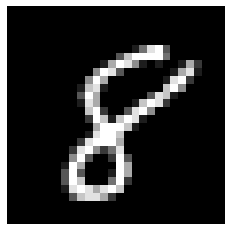

In [8]:
random_index = np.random.randint(0, X.shape[0], 1)
random_digit = X[random_index]

plt.imshow(random_digit.reshape((28,28)), cmap='gray')
_ = plt.axis('off')

#### Демонстрация распределения данных

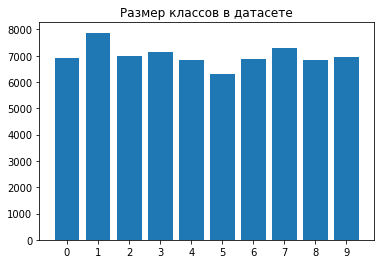

In [9]:
plt.hist(y, bins=range(11), histtype='bar', rwidth=0.8, align='left')
plt.xticks(range(10))
plt.title("Размер классов в датасете")
plt.show()

Делаем вывод, что распределение объектов по классам примрно равномерно, поэтому далее можно брать случайные объекты датасета.

#### Обучение модели мультиномиальной логистической регрессии 

Делим датасет на тренировочную и тестовую выборку. В тренировочной выборке будет 60000 объектов, в тестовой -- 10000

In [10]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X, y, test_size=10000)
print(Xtrain.shape)
print(ytrain.shape)

(60000, 784)
(60000,)


Обучаем логистическую регрессию:

In [11]:
sample_size = Xtrain.shape[0]
Xtr,ytr,Xoob,yoob = sample_bootstrap(Xtrain,ytrain, sample_size=sample_size, return_OOB_sample=True)
MLR = LogisticRegression()
MLR.fit(Xtr, ytr)
yoob_pred = MLR.predict(Xoob)
yoob_proba = MLR.predict_proba(Xoob)
print('accuracy: ' + str(np.mean(np.squeeze(yoob_pred)==yoob)))

accuracy: 0.9144818119423472


#### Применение модели

probability of predicted class: 0.953486
true class: 2
pred class: 2


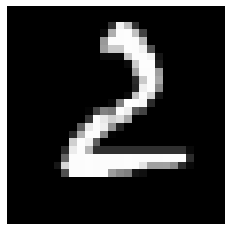

In [14]:
idx = np.random.randint(0, Xtest.shape[0])
x1 = Xtest[idx,:][np.newaxis,:]
y1_proba = MLR.predict_proba(x1)

print('probability of predicted class: %f' % y1_proba[0][np.argmax(y1_proba)])

y1_pred = MLR.predict(x1)

print('true class: %d\npred class: %d' % (ytest[idx], y1_pred[0]))

plt.imshow(x1.reshape((28,28)), cmap='gray')
_ = plt.axis('off')

### Оценка качества модели
Получим меры качества модели на тестовой выборке. Используются стандартные функции sklearn

In [15]:
ytest_pred = MLR.predict(Xtest) # ответы модели для тестовой выборки
ytest_proba = MLR.predict_proba(Xtest) # вероятности классов для объектов тестовой выборки
CM = metr.confusion_matrix(ytest, ytest_pred)
print(CM)

# print('accuracy: ' + str(np.mean(np.squeeze(ytest_pred)==ytest)))
print('accuracy: ' + str(np.round(metr.accuracy_score(ytest, ytest_pred),4)))
print('precision: ' + str(np.round(metr.precision_score(ytest, ytest_pred, average='macro'),4)))
print('recall: ' + str(np.round(metr.recall_score(ytest, ytest_pred, average='macro'),4)))
print('F1: ' + str(np.round(metr.f1_score(ytest, ytest_pred, average='macro'),4)))

[[ 928    1    4    0    4    8    7    3    6    1]
 [   0 1076    8    4    0    8    1    3    9    2]
 [   8   12  912   22   16    7    9    6   21    1]
 [   3    5   16  896    2   28    3    9   21   12]
 [   2    6    9    2  899    4   11    3   11   32]
 [  10    4    7   31    8  782   11    7   26    8]
 [   6    5   12    1    9   15  943    2    6    2]
 [   1    5   16   10   14    3    0  951    0   41]
 [   5   25   19   31    3   38    6    2  874   15]
 [   7    5    1   12   28   12    0   31    8  881]]
accuracy: 0.9142
precision: 0.9134
recall: 0.9135
F1: 0.9134


#### Оценка неопределенности меры качества модели

##### Подбор оптимального количества bootstrap-выборок

In [16]:
def sample_bootstrap(X, y, sample_size, return_OOB_sample = False):
    sample_indices = np.random.randint(0,X.shape[0], sample_size)
    if return_OOB_sample:
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices])
        return X[sample_indices, :], y[sample_indices], X[oob_indices, :], y[oob_indices]
    else:
        return X[sample_indices, :], y[sample_indices]

Пусть размер bootstrap-выборок B=5000. Найдем оптимальное количнество выборок Nb - такое, при котором значение неопределенности меры качества (в нашем случае - СКО) выходит на постоянное значение и перестает меняться с ростом числа выборок

In [17]:
Nb = 10 # изменяю в диапазоне от 10 до 1000
sample_size = 5000
accuracy_per_Nb_q = []
prescision_per_Nb_q = []
recall_per_Nb_q = []
f1_per_Nb_q = []

for Nb in np.linspace(10, 1000, 20):
    Nb = round(Nb)
    accuracy_cur_Nb = []
    prescision_cur_Nb = []
    recall_cur_Nb = []
    f1_cur_Nb = []
    for i in tqdm(range(Nb), total=Nb):
        Xtrain,ytrain = sample_bootstrap(X,y, sample_size=sample_size)
        MLR = LogisticRegression()
        MLR.fit(Xtrain,ytrain)
        ytest_pred = MLR.predict(Xtest) # ответы модели для тестовой выборки
        # ytest_proba = MLR.predict_proba(Xtest) # вероятности классов для объектов тестовой выборки
        accuracy_cur_Nb.append(metr.accuracy_score(ytest, ytest_pred)) 
        prescision_cur_Nb.append(metr.precision_score(ytest, ytest_pred, average='macro')) 
        recall_cur_Nb.append(metr.recall_score(ytest, ytest_pred, average='macro'))
        f1_cur_Nb.append(metr.f1_score(ytest, ytest_pred, average='macro'))      
    accuracy_per_Nb_q.append({'sample_number': Nb, 'accuracy': accuracy_cur_Nb})
    prescision_per_Nb_q.append({'sample_number': Nb, 'prescision': prescision_cur_Nb})
    recall_per_Nb_q.append({'sample_number': Nb, 'recall': recall_cur_Nb})
    f1_per_Nb_q.append({'sample_number': Nb, 'f1': f1_cur_Nb})

100%|██████████| 1000/1000 [31:42<00:00,  1.90s/it]


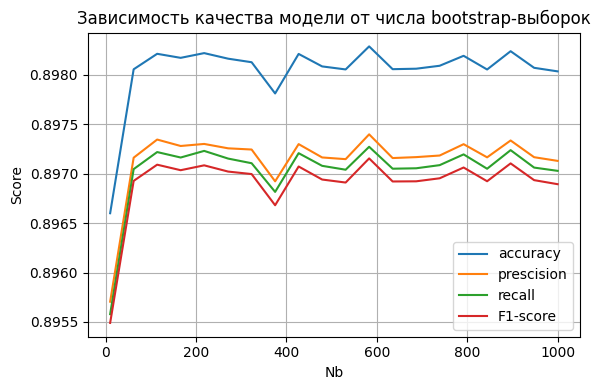

In [173]:
f = plt.figure(figsize=(6,4), dpi=100)
plt.plot([t['sample_number'] for t in accuracy_per_Nb_q],
            [np.mean(t['accuracy'][:]) for t in accuracy_per_Nb_q], label="accuracy")
plt.plot([t['sample_number'] for t in accuracy_per_Nb_q],
            [np.mean(t['prescision'][:]) for t in prescision_per_Nb_q], label="prescision")
plt.plot([t['sample_number'] for t in accuracy_per_Nb_q],
            [np.mean(t['recall'][:]) for t in recall_per_Nb_q], label="recall")
plt.plot([t['sample_number'] for t in accuracy_per_Nb_q],
            [np.mean(t['f1'][:]) for t in f1_per_Nb_q], label="F1-score")
plt.ylabel('Score')
plt.xlabel('Nb')
plt.legend()
plt.grid()
plt.title("Зависимость качества модели от числа bootstrap-выборок")
plt.tight_layout()

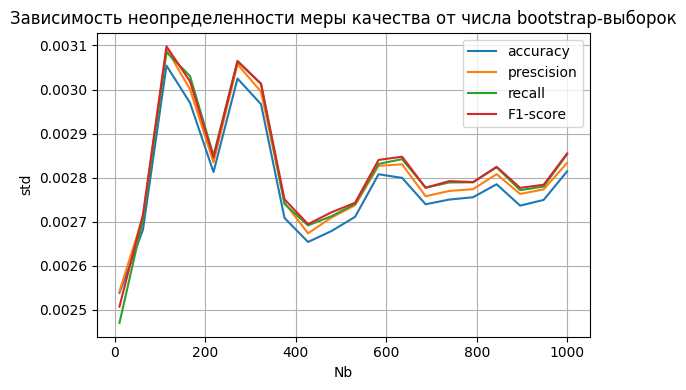

In [172]:
f = plt.figure(figsize=(6,4), dpi=100)
plt.plot([t['sample_number'] for t in accuracy_per_Nb_q],
            [np.std(t['accuracy'][:]) for t in accuracy_per_Nb_q], label="accuracy")
plt.plot([t['sample_number'] for t in accuracy_per_Nb_q],
            [np.std(t['prescision'][:]) for t in prescision_per_Nb_q], label="prescision")
plt.plot([t['sample_number'] for t in accuracy_per_Nb_q],
            [np.std(t['recall'][:]) for t in recall_per_Nb_q], label="recall")
plt.plot([t['sample_number'] for t in accuracy_per_Nb_q],
            [np.std(t['f1'][:]) for t in f1_per_Nb_q], label="F1-score")
plt.ylabel('std')
plt.xlabel('Nb')
plt.legend()
plt.grid()
plt.title("Зависимость неопределенности меры качества от числа bootstrap-выборок")
plt.tight_layout()

Фиксируем оптимальное число bootstrap-выборок Nb = 200

##### Подбор оптимального размера bootstrap-выборок

In [165]:
Nb=200
accuracy_per_sample_size = []
prescision_per_sample_size = []
recall_per_sample_size = []
f1_per_sample_size = []
for sample_size in np.linspace(2000, 50000, 5):
    print(int(sample_size))
    accuracy_cur_sample_size = []
    prescision_cur_sample_size = []
    recall_cur_sample_size = []
    f1_cur_sample_size = []
    for i in tqdm(range(Nb), total=Nb):
        Xtrain,ytrain = sample_bootstrap(X,y, sample_size=int(sample_size))
        MLR = LogisticRegression()
        MLR.fit(Xtrain,ytrain)
        ytest_pred = MLR.predict(Xtest)
        accuracy_cur_sample_size.append(metr.accuracy_score(ytest, ytest_pred)) 
        prescision_cur_sample_size.append(metr.precision_score(ytest, ytest_pred, average='macro')) 
        recall_cur_sample_size.append(metr.recall_score(ytest, ytest_pred, average='macro'))
        f1_cur_sample_size.append(metr.f1_score(ytest, ytest_pred, average='macro'))      
    accuracy_per_sample_size.append({'sample_size': sample_size, 'accuracy': accuracy_cur_sample_size})
    prescision_per_sample_size.append({'sample_size': sample_size, 'prescision': prescision_cur_sample_size})
    recall_per_sample_size.append({'sample_size': sample_size, 'recall': recall_cur_sample_size})
    f1_per_sample_size.append({'sample_size': sample_size, 'f1': f1_cur_sample_size})

2000


100%|██████████| 200/200 [02:34<00:00,  1.29it/s]


14000


100%|██████████| 200/200 [23:33<00:00,  7.07s/it]


26000


100%|██████████| 200/200 [40:59<00:00, 12.30s/it]


38000


100%|██████████| 200/200 [58:13<00:00, 17.47s/it]


50000


100%|██████████| 200/200 [1:18:48<00:00, 23.64s/it]


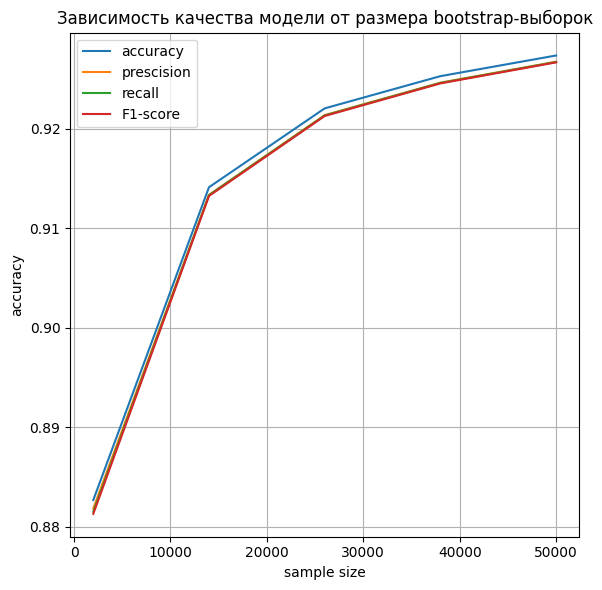

In [170]:
f = plt.figure(figsize=(6,6), dpi=100)
plt.plot([t['sample_size'] for t in accuracy_per_sample_size],
            [np.mean(t['accuracy'][:]) for t in accuracy_per_sample_size], label="accuracy")
plt.plot([t['sample_size'] for t in accuracy_per_sample_size],
            [np.mean(t['prescision'][:]) for t in prescision_per_sample_size], label="prescision")
plt.plot([t['sample_size'] for t in accuracy_per_sample_size],
            [np.mean(t['recall'][:]) for t in recall_per_sample_size], label="recall")
plt.plot([t['sample_size'] for t in accuracy_per_sample_size],
            [np.mean(t['f1'][:]) for t in f1_per_sample_size], label="F1-score")
plt.ylabel('accuracy')
plt.xlabel('sample size')
plt.legend()
plt.grid()
plt.title("Зависимость качества модели от размера bootstrap-выборок")
plt.tight_layout()

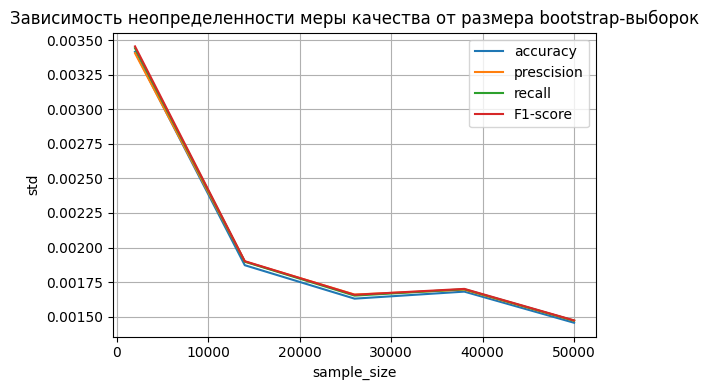

In [171]:
f = plt.figure(figsize=(6,4), dpi=100)
plt.plot([t['sample_size'] for t in accuracy_per_sample_size],
            [np.std(t['accuracy'][:]) for t in accuracy_per_sample_size], label="accuracy")
plt.plot([t['sample_size'] for t in accuracy_per_sample_size],
            [np.std(t['prescision'][:]) for t in prescision_per_sample_size], label="prescision")
plt.plot([t['sample_size'] for t in accuracy_per_sample_size],
            [np.std(t['recall'][:]) for t in recall_per_sample_size], label="recall")
plt.plot([t['sample_size'] for t in accuracy_per_sample_size],
            [np.std(t['f1'][:]) for t in f1_per_sample_size], label="F1-score")
plt.ylabel('std')
plt.xlabel('sample_size')
plt.legend()
plt.grid()
plt.title("Зависимость неопределенности меры качества от размера bootstrap-выборок")
plt.tight_layout()

Видно что с увеличением числа объектов в выборке качество модели растет, а неопределенность меры качества падает. Однако проверять наборы более крупных выборок очень долго, поэтому остановимся на размере выборок sample_size = 50000

##### Оценка среднего значения и неопределенности меры качества
Фиксируем число bootstrap-выборок Nb = 200, размер выборок 50000

In [56]:
Nb=200
sample_size=50000

Выделим тестовую выборку, которая не будет участвовать в обучении моделей, и на которой затем будем оценивать качество модели

In [180]:
Xtrain_0,Xtest,ytrain_0,ytest = train_test_split(X, y, test_size=20000)

Используем метод bootstrap: обучим Nb моделей на различных выборках из тренировочной выборки, для каждой модели зафиксируем её ответы, вероятности классов, меру качества. Затем получим средние по всем выборкам вероятности классов на тестовой выборке, среднюю меру качества, а также вычислим неопределенность меры качества (СКО)

In [244]:
accuracy_test = [] # Nb --> np.std(accuracy_test) -- оценка неопределенности меры качества
proba_test = [] # 20000*10*Nb --> матрица вероятностей классов

accuracy_oob = [] # Nb --> np.std(accuracy_test) -- оценка неопределенности меры качества
proba_oob = [] # oob_size*10*Nb 

for i in tqdm(range(Nb), total=Nb):
    Xtrain, ytrain, Xoob, yoob = sample_bootstrap(Xtrain_0,ytrain_0, sample_size=int(sample_size),  return_OOB_sample = True)
    MLR = LogisticRegression()
    MLR.fit(Xtrain,ytrain)

    y_pred = MLR.predict(Xtest) # ответы модели для тестовой выборки
    y_proba = MLR.predict_proba(Xtest) # вероятности классов для объектов тестовой выборки

    yoob_pred = MLR.predict(Xoob) # ответы модели для oob выборки
    yoob_proba = MLR.predict_proba(Xoob) # вероятности классов для объектов oob выборки

    accuracy_test.append(metr.accuracy_score(ytest, y_pred))
    proba_test.append(y_proba)
    accuracy_oob.append(metr.accuracy_score(yoob, yoob_pred))
    proba_oob.append(yoob_proba)


100%|██████████| 200/200 [1:34:19<00:00, 28.30s/it]


In [245]:
print("Средняя по 200 моделям мера качества (accuracy): ") 
accuracy_mean = np.mean(accuracy_test)
print("на тестовой выборке: ", accuracy_mean)
accuracy_oob_mean = np.mean(accuracy_oob)
print("на oob-выборках: ", accuracy_oob_mean)

Средняя по 200 моделям мера качества (accuracy): 
на тестовой выборке:  0.9137027499999999
на oob-выборках:  0.9153167820069883


In [246]:
print("Средняя по 200 моделям неопределенность меры качества (СКО): ") 
accuracy_std = np.std(accuracy_test)
print("на тестовой выборке: ", accuracy_std)
accuracy_oob_std = np.std(accuracy_oob)
print("на oob-выборках ", accuracy_oob_std)

Средняя по 200 моделям неопределенность меры качества (СКО): 
на тестовой выборке:  0.0011860353862764804
на oob-выборках  0.001964641983080733


In [277]:
# Осредним по Nb выборкам вероятности каждого класса для всех объектов тестовой выборки
mean_proba = np.mean(proba_test, axis=0)
np.shape(mean_proba)

(20000, 10)

In [278]:
# Вычислим по Nb выборкам СКО вероятности каждого класса для объектов тестовой выборки
proba_std = np.std(proba_test, axis=0)
np.shape(proba_std)

(20000, 10)

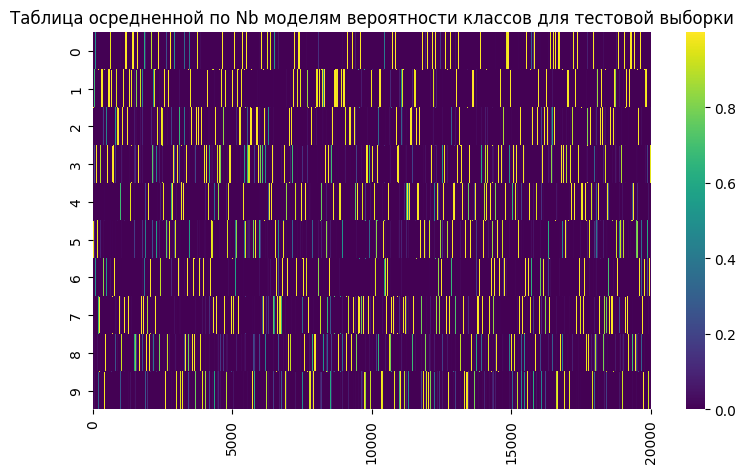

In [362]:
f = plt.figure(figsize=(9,5), dpi=100)
ax = sns.heatmap(np.transpose(mean_proba), cmap='viridis')
plt.title("Таблица осредненной по Nb моделям вероятности классов для тестовой выборки")
plt.xticks(np.linspace(0, 20000, 5), np.linspace(0, 20000, 5, dtype='int'))
plt.show()

In [266]:
# Отсортируем вероятности и СКО вероятностей по классам в тестовой выборке
A = list(zip(ytest, mean_proba))
A.sort(key=lambda x: x[0])
sorted_mean_proba = [a[1] for a in A]

B = list(zip(ytest, proba_std))
B.sort(key=lambda x: x[0])
sorted_proba_std = [a[1] for a in B]

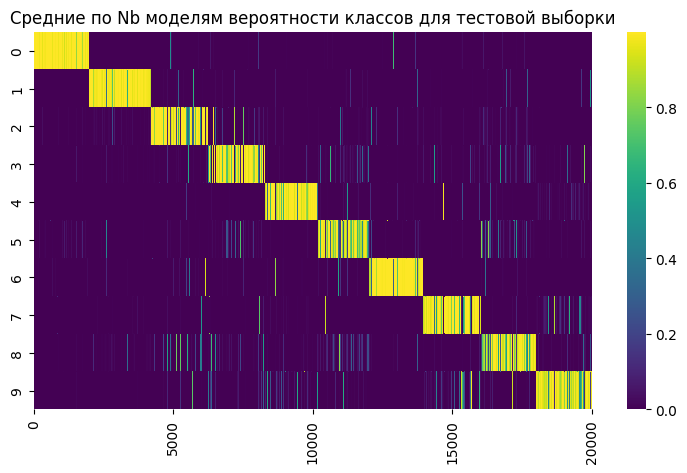

In [273]:
f = plt.figure(figsize=(9,5), dpi=100)
ax = sns.heatmap(np.transpose(sorted_mean_proba), cmap='viridis')
plt.title("Средние по Nb моделям вероятности классов для тестовой выборки")
plt.xticks(np.linspace(0, 20000, 5), np.linspace(0, 20000, 5, dtype='int'))
plt.show()

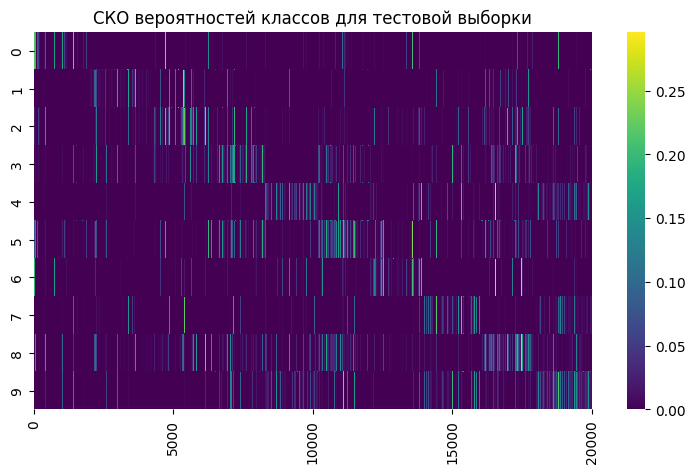

In [275]:
f = plt.figure(figsize=(9,5), dpi=100)
ax = sns.heatmap(np.transpose(sorted_proba_std), cmap='viridis')
plt.title("СКО вероятностей классов для тестовой выборки")
plt.xticks(np.linspace(0, 20000, 5), np.linspace(0, 20000, 5, dtype='int'))
plt.show()

(объекты тестовой выборки отсортированы по классам)  
Из матриц вероятностей выше можно сделать вывод, что модель лучше всего различает цифры 0 и 1, а наименее уверенные ответ модель дает для 2 и 8. Можно заметить и другие особенности: например, модель может путать цифры 4 и 9, 3 и 5, 2 и 8

#### Применение обученной модели

In [279]:
Xtrain, ytrain = sample_bootstrap(Xtrain_0,ytrain_0, sample_size=int(sample_size),  return_OOB_sample = False)
MLR = LogisticRegression()
MLR.fit(Xtrain,ytrain)

y_pred = MLR.predict(Xtest) # ответы модели для тестовой выборки
y_proba = MLR.predict_proba(Xtest) # вероятности классов для объектов тестовой выборки


In [282]:
print("Мера качества одной модели: accuracy = ", metr.accuracy_score(ytest, y_pred))

Мера качества одной модели: accuracy =  0.91265


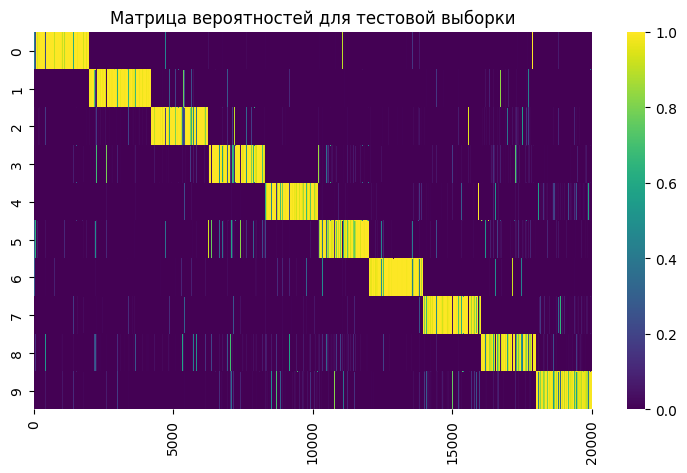

In [284]:
A = list(zip(ytest, y_proba))
A.sort(key=lambda x: x[0])
sorted_y_proba = [a[1] for a in A]

f = plt.figure(figsize=(9,5), dpi=100)
ax = sns.heatmap(np.transpose(sorted_y_proba), cmap='viridis')
plt.title("Матрица вероятностей для тестовой выборки")
plt.xticks(np.linspace(0, 20000, 5), np.linspace(0, 20000, 5, dtype='int'))
plt.show()

##### Поиск выбросов
Найдем 5 примеров, для которых неопределенность для превалирующего для них класса максимальна

In [290]:
C = np.zeros((20000))
for i in range(20000):
    cl = int(y_pred[i])
    C[i] = proba_std[i, cl]

print(C)

[8.10075257e-05 2.50146347e-05 5.28479495e-03 ... 1.55625249e-06
 1.32433857e-03 2.91291912e-02]


In [357]:
max_uncert_ind=np.argsort(C)[::-1][:5]
print(max_uncert_ind)

[ 6172 17629  5467  3431 19610]


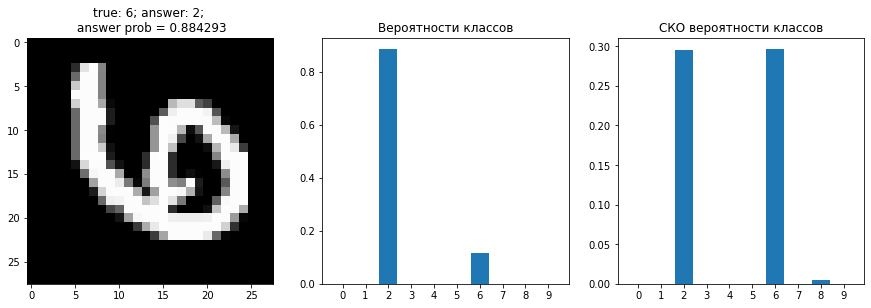

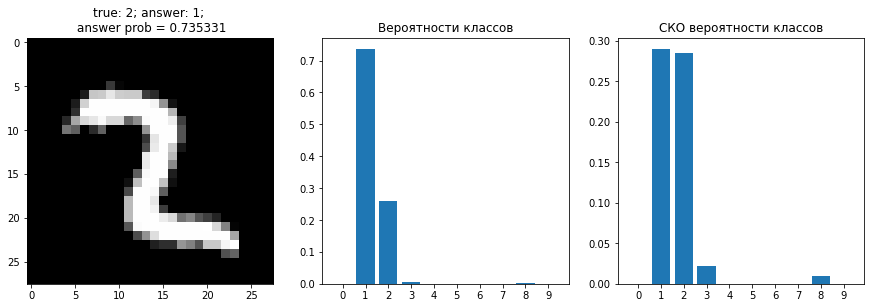

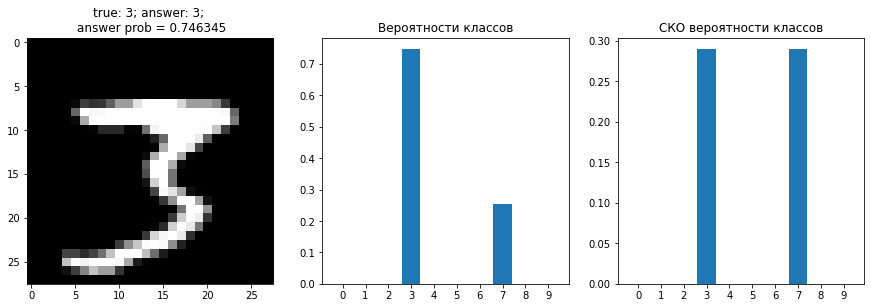

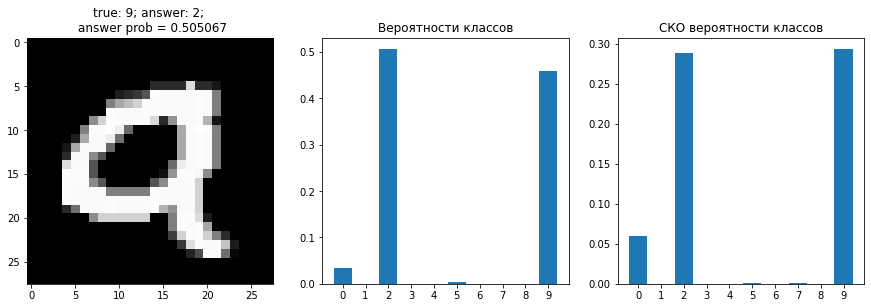

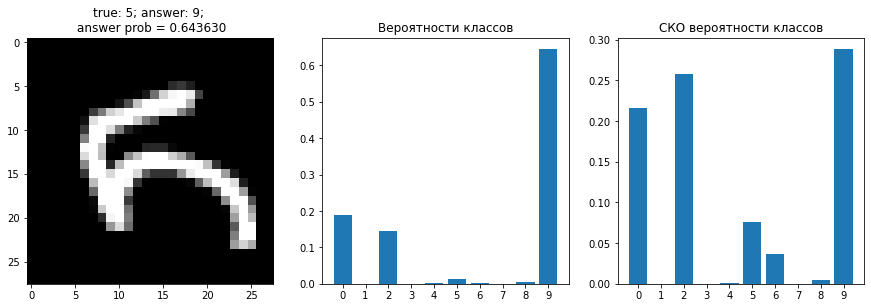

In [359]:
for i in range(5):
    fig, ax= plt.subplots(1, 3, figsize=(15, 10))
    ind=max_uncert_ind[i]
    y_true = ytest[ind]
    y_ans = y_pred[ind]
    proba_pred = y_proba[ind, int(y_ans)] # вероятность превалирующего класса
    probas = y_proba[ind]
    probas_std = proba_std[ind]

    ax[0].imshow(Xtest[ind,:].reshape((28,28)), cmap='gray')
    ax[0].title.set_text('true: %d; answer: %d; \n answer prob = %f' % (y_true, y_ans, proba_pred))

    ax[1].bar(np.linspace(0, 9, 10), probas)
    asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
    ax[1].set_xticks(np.linspace(0, 9, 10))
    ax[1].set_aspect(asp)
    ax[1].title.set_text('Вероятности классов')

    ax[2].bar(np.linspace(0, 9, 10), probas_std)
    asp = np.diff(ax[2].get_xlim())[0] / np.diff(ax[2].get_ylim())[0]
    ax[2].set_xticks(np.linspace(0, 9, 10))
    ax[2].set_aspect(asp)
    ax[2].title.set_text('СКО вероятности классов')

    plt.show()

Таким образом, мы нашли "плохие" объекты из тестовой выборки. Изначально такие объекты плохого качества (цифра недописана или написана криво, неровно - так что и человек не всегда поймет что за цифра написана), и модель, как видно, обычно не может верно распознать такой объект. У таких объектов вероятность превалирующего класса не высокая, выделюятся и другие классы со сравнимой вероятностью, и неопределенность вероятности для этих классов также оказыватся высокой